In [12]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


os.chdir("C:/Users/danie/Documents/GitHub/Machine-Learning-Portfolio")
print(os.getcwd())

C:\Users\danie\Documents\GitHub\Machine-Learning-Portfolio


In [ ]:
# DO NOT RUN THIS CODE, IT TAKES FOREVER
# creating the BikeTrips csv
folder_path = 'data'
filtered_data = []

# Loop through all files in the folder
for file_name in os.listdir(folder_path):
    # Ensure only CSV files are processed
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        
        # Read the current CSV file
        df = pd.read_csv(file_path)

        # Append the filtered DataFrame to the list
        filtered_data.append(df)

# Combine all filtered DataFrames into one
if filtered_data:
    divvy_df = pd.concat(filtered_data, ignore_index=True)
    print("All files have been processed and merged.")
    
    # Save the final merged DataFrame to a new CSV
    divvy_df.to_csv('BikeTrips.csv', index=False)
    print("Filtered data saved to 'BikeTrips.csv'.")
else:
    print("No data was filtered or no files were processed.")



In [3]:
#reading in the data and doing some initial data cleaning/preperation before fitting/training the models

df = pd.read_csv("BikeTrips.csv")
df = df.drop(["start_station_id", "end_station_id"], axis = 1)

In [4]:
#identifying the length of each individual ride
df["ended_at"] = pd.to_datetime(df["ended_at"])
df["started_at"] = pd.to_datetime(df["started_at"])
df["ride length"] = ((df["ended_at"] - df["started_at"]).dt.total_seconds())/60

#filtering out weird values that are below or greater than one day
df = df[(df["ride length"] > 0) & (df["ride length"] < 1440)]

#identifying the date that the ride occurred
df["date"] = df["started_at"].dt.strftime("%Y-%m-%d")
df["date"] = pd.to_datetime(df["date"])

# going to normalize the longitude and latitude from State and Madison, the 0,0 point in the Chicago grid system
# State and Madison is located at (41.8818633,-87.6277364), per google maps

df["start_lat"] = (df["start_lat"] / 41.8818633) - 1        # the values here are such that when I have zero, I am at State and Madison
df["end_lat"] = (df["end_lat"] / 41.8818633) - 1
df["start_lng"] = (df["start_lng"] / (-87.6277364) - 1)
df["end_lng"] = (df["end_lng"] / (-87.6277364) - 1)

#adding the summer condition for rideable months
df["summer"] = 0
df.loc[(df["date"] > "2023-03-01") & (df["date"] < "2023-10-31"), "summer"] = 1
df=df.dropna()

In [5]:
#creating the rainy day indicator, note that this is a random value
unique_dates = df["date"].unique()
rain_day = list(np.random.choice([0,1], size = len(unique_dates)))

rainy_day_df = pd.DataFrame({"date" : unique_dates,
                            "rain" : rain_day})
df = df.merge(rainy_day_df, how = "left", on = "date")


In [ ]:
# I want to find a way to predict the way that rain has an effect on the length of rides
# seperately, i would want to find out how rain has an effect on the number of rides per day


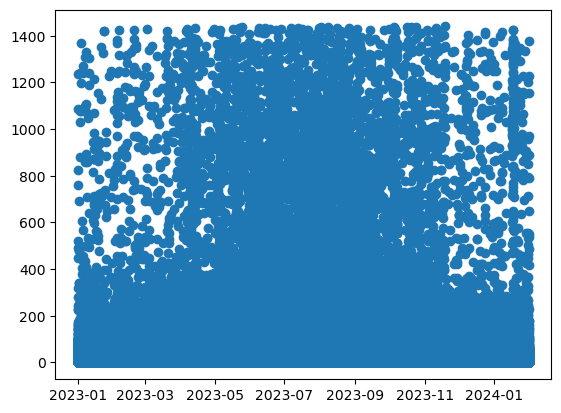

In [70]:
# quick visualization
plt.scatter((df["date"]), df["ride length"])
plt.show()

In [40]:
#creating the linear regression using scikit learn
#splitting train and test data
X = df[["summer", "rain", "start_lat", "start_lng", "end_lat", "end_lng"]]
y = df["ride length"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)

#training the model
model = LinearRegression()
model.fit(X_train, y_train)

# generating predcitions for the test data
y_pred = model.predict(X_test)

print(mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred))
print()
print(model.coef_, model.intercept_)


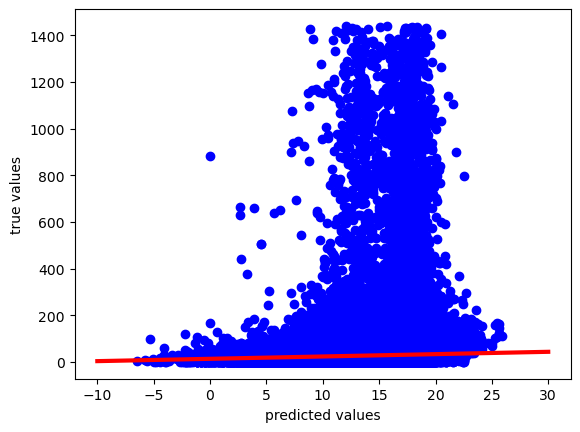

In [67]:
#plotting the predictions against the test data
x = np.linspace(-10,30)
b = model.intercept_
m = 1
y = m*x+b

plt.scatter(y_pred, y_test, color = "blue")
plt.plot(x, y, color = "red", linewidth = 3)
plt.ylabel("true values")
plt.xlabel("predicted values")
plt.show()

#not a good model. really low r squared, which means that the mdoel is not doing anything better than the mean of the dataset.